# "Photometry FLMM Guide Part I : Data Formating and Binary Variables"
## Authors: "Gabriel Loewinger, Erjia Cui"

## Introduction

`fastFMM` is a fast toolkit for fitting Functional Linear Mixed Models (FLMM). Instead of analyzing summary measures of photometry signals (e.g., Area-Under-the-Curve, peak amplitude), FLMM allows you to analyze the relationship between photometry signals and experimental/behavioral variables (e.g., CS+/CS-, total presses, treatment/control groups) at each time-point of the trial. Therefore, FLMM provides a unique opportunity to reveal potentially time-varying signal changes that are obscured by analyzing only summary measures (e.g., see [Loewinger et al. (2023)](https://www.biorxiv.org/content/10.1101/2023.11.06.565896v1)). Although our package can fit the wider class of generalized functional mixed models, this guide focuses on FLMM. 


# Installation

## fastFMM Installation on R

The CRAN version of `fastFMM` can be downloaded by executing the following command on your R console:

```{r, eval=FALSE}
install.packages("fastFMM", dependencies = TRUE)
```

*May want to mention RENV here or maybe chat with Gabe about what is easiest*

## Package Installation for Python

This tutorial `pandas` to read in the data into Python and `rpy2` to pass the data in Python to the fastFMM model in R.

In [1]:
%pip install pandas
%pip install rpy2

import pandas as pd



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Loading fastFMM using rpy2

In order to pass data into fastFMM we first must load the pandas2ri module and activate. We then import the required R packages, including fastFMM, into Python using importr

In [2]:

from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr


pandas2ri.activate()

# import R packages
base = importr("base")
utils = importr("utils")
stats = importr("stats")
fastFMM = importr("fastFMM")


# Tutorial Guide

We start by analyzing trial-level photometry signals (each trial is a 5 second $\Delta F/ F$ signal) collected from multiple animals, on multiple sessions (each of which contains multiple trials). You can pre-process your data in any programming language you like, but it is recommended to save the processed dataset as a CSV file to then read into R.

## Data Formating

For demonstration purpose, we have pre-processed a dataset stored as `binary.csv`. This data was taken from Test 4 of [Jeong et al., 2022](https://www.science.org/doi/full/10.1126/science.abq6740) and we thank the authors for generously making their data public and helping us analyze it.

Let's load the data and take a look at its structure of the first several columns. Please make sure to either set your working directory in R first using `setwd()` function, or specify the file pathname in the `read.csv('path/to/file/photometry_data.csv')`. 

Below we will load the data using Pandas and then pass the DataFrame to R using robjects.

In [3]:
# read in data
df = pd.read_csv("binary.csv")

# convert it to an R variable
robjects.globalenv["df"] = df

#display subset of data
df.iloc[:10, :10].round(3)


,id,session,trial,cs,photometry.1,photometry.2,photometry.3,photometry.4,photometry.5,photometry.6
0,3,1,1.0,0,-0.810,-0.626,-0.484,-0.414,-0.336,-0.335
1,3,1,2.0,0,-0.037,-0.136,0.005,-0.022,0.029,0.251
2,3,1,3.0,0,-0.241,-0.058,0.037,-0.075,-0.242,-0.276
3,3,1,4.0,0,0.058,0.032,-0.041,0.080,0.062,-0.047
4,3,1,5.0,0,-0.134,0.024,0.017,-0.128,-0.108,-0.086
5,3,1,6.0,0,-0.547,-0.547,-0.444,-0.380,-0.309,-0.329
6,3,1,7.0,0,-0.148,-0.270,-0.304,-0.116,-0.069,0.013
7,3,1,8.0,0,0.772,0.868,0.975,1.071,1.027,1.210
8,3,1,9.0,0,0.434,0.335,0.181,0.096,0.081,0.195
9,3,1,10.0,0,-0.284,-0.208,-0.129,0.013,0.256,0.281


The dataset pools trials across animals, and sessions. Each row is a single trial and contains both experimental information and the values of the photometry signal at each of 125 trial timepoints. The first 4 columns of this dataset include the subject ID ($\texttt{id}$), session number ($\texttt{session}$), trial number ($\texttt{trial}$), and cue type CS+/CS- ($\texttt{cs}$). Since the first 6 trials in the dataset are all from animal 3 on session 1, the values of the $\texttt{id}$ and $\texttt{session}$ entry are the same for these rows. If we looked further down in the dataset, we would see other values in the $\texttt{id}$ and $\texttt{session}$ columns. Note that the actual ordering of these first four columns does not matter, that is, it is not necessary to reorder the data for the analysis. The column $\texttt{cs}$ is a covariate of interest and indicates whether the trial was a CS+ trial ($cs = 0$), or a CS- trial ($cs = 1$). The remaining columns contain the photometry signal values (e.g., $\Delta F / F$). We have 125 photometry values stored in columns $\texttt{photometry.1}$, $\texttt{photometry.2}$, ..., $\texttt{photometry.125}$ because the trials are 5 seconds long and the signal was downsampled to 25 Hz. 

With such data structures, we can specify an FLMM using the `fui()` function. The function assumes that whatever character string used to label the columns for the photometry signal preceeding the "." only occurs in columns corresponding to the signal. For example, if we specified a model `fui(photometry ~ cue + (1 | id), ...`, then all columns starting with 'photometry.', will be interpreted as the photometry signal (here we use $\texttt{photometry.}$, but we could have used anything else, such as $\texttt{Y.}$). For that reason we recommend not naming other variables in your dataset using names that contain the same characters as the response(e.g., $\texttt{photometryAUC}$). Similarly, please do not name other variables with a period '.'. A safe variable name could be $\texttt{photo\_AUC}$ to avoid any issues with the analysis code.

Alternatively, instead of relying on the column names, we can save the $N \times L$ matrix associated with our photometry signals as a variable of a dataframe using the `I()` function. The `fui()` function accepts either format style.

## Model Fitting and Function Arguments

The `fui()` function syntax begins with the functional outcome $\texttt{photometry}$ followed by $\texttt{\(\sim \)}$, then the fixed-effect covariates (here we only have binary one: $\texttt{cs}$), and the random effects inside the parentheses: (e.g., $\texttt{(1 | id)}$). The motivation of including random effects is to model the variability of photometry signal profiles across animals and to model the dependence arising $across$ trials within the same animals. To the left of the $\texttt{|}$ are the covariates included for random-effects (here a $\texttt{1}$ means only a random intercept is included. But if we wanted a random-slope for $\texttt{cs}$, we would write $(\texttt{cs | id})$. To the right of the $\texttt{|}$ indicates the cluster or grouping variable. For us, this will usually be animal $\texttt{id}$. We specify the name of our data object in $\texttt{R}$, which we have just called `dat`. The syntax is based off of the `lmer()` function in the `lme4` package. Finally, we set `parallel = TRUE` to parallelize the function. This often substantially speeds up the code. It is not necessary though, and will not influence the model fit.

Let's explore a few simple questions to understand how we might go about conducting FLMM analyses similar to common analyses like t-tests, correlations, repeated-measures ANOVAs, etc.

## Binary covariate: Akin to FLMM version of a paired t-test: 

We begin by analyzing data from a Pavlovian task in which a reward-predictive CS+ and a CS- (not predictive of reward). We can compare the mean differences between CS+/CS- in photometry signal magnitude at each trial timepoint. This is akin to 1) taking an average trace for CS+ trials, 2) calculating an average trace for CS- trials, 3) taking the difference (at each timepoint) between the two average traces, and 3) examining where the difference in the average trace is significantly different than 0 (i.e., trial timepoints on CS+ trials in which the mean dF/F was significantly different than the mean dF/F at those timepoints on CS- trials).

Let's start with a simple model, which can be viewed as the functional version of a paired t-test: we fit models with the binary $\texttt{cs}$ covariate as the only predictor. This gives us a trial timepoint-by-timepoint test of whether there are significant differences in the photometry signal between CS+ and CS- trials. The figure output will show whether the mean signal was significantly higher/lower on CS+ trials than on CS- trials at trial timepoint 1, 2, 3, etc.

We can fit a model and plot the output in 2 lines of code. Pretty easy, right?

[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R[write to console]: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui



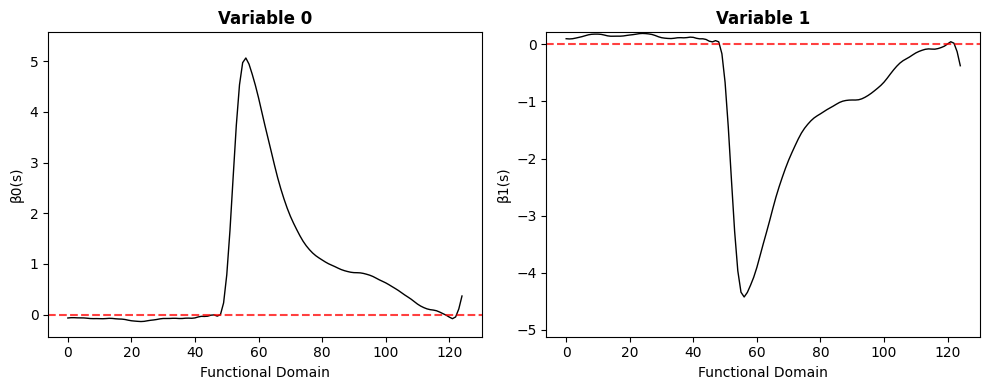

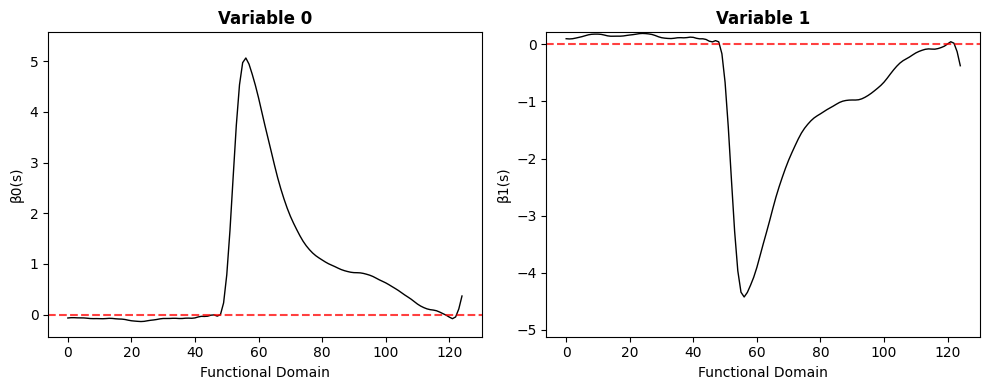

In [11]:
# fit an FUI model
from plot_fui import plot_fui

mod = fastFMM.fui(
    stats.as_formula("photometry ~ cs + (1 | id)"), data=base.as_symbol("df")
)

# convert m1 to dict
mod_dict: dict = {}
for item in m1.items():
    mod_dict[str(item[0])] = item[1]

plot_fui(mod_dict)


In [24]:
type(mod)


rpy2.robjects.vectors.ListVector

In [25]:
mod.names


array(['betaHat', 'betaHat.var', 'qn', 'aic', 'betaTilde', 'var_random',
       'designmat', 'residuals', 'H', 'R', 'G', 'GHat', 'Z', 'argvals',
       'randEff', 'se_mat'], dtype='<U11')

In [36]:
mod.rx2('betaHat')


array([[-6.66771720e-02, -6.08122681e-02, -6.06527128e-02,
        -6.36982355e-02, -6.45967327e-02, -6.53591696e-02,
        -7.06238534e-02, -7.73551256e-02, -7.94849825e-02,
        -7.86249985e-02, -7.99262936e-02, -8.13722910e-02,
        -7.80534958e-02, -7.35293130e-02, -7.54041717e-02,
        -8.22205928e-02, -8.64970801e-02, -8.88208803e-02,
        -9.66816943e-02, -1.10226789e-01, -1.21479398e-01,
        -1.27632069e-01, -1.32882310e-01, -1.36679867e-01,
        -1.32862199e-01, -1.21992578e-01, -1.12136478e-01,
        -1.05367476e-01, -9.58713072e-02, -8.35727010e-02,
        -7.64889780e-02, -7.64906379e-02, -7.60917123e-02,
        -7.28942381e-02, -7.31914810e-02, -7.72917950e-02,
        -7.66849231e-02, -7.07894047e-02, -6.94542463e-02,
        -7.23173697e-02, -6.51576268e-02, -4.62217557e-02,
        -3.41845040e-02, -3.58887849e-02, -3.10108026e-02,
        -1.10086066e-02, -5.90074131e-03, -2.93759590e-02,
        -1.88896398e-03,  2.31178157e-01,  7.87218790e-0